In [ ]:
%tensorflow_version 2.x

In [ ]:
from tensorflow import keras
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import re
import gensim
from gensim.models import word2vec
import tensorflow as tf
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en.examples import sentences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, hashing_trick, text_to_word_sequence
# from tensorflow.keras.preprocessing.text import hashing_trick
# from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [ ]:
df_news = pd.read_csv("train.csv", error_bad_lines=False, engine="python")


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 13535: field larger than field limit (131072)
Skipping line 19783: field larger than field limit (131072)
Skipping line 13541: Expected 5 fields in line 13541, saw 6
Skipping line 19782: Expected 5 fields in line 19782, saw 7
Skipping line 19783: Expected 5 fields in line 19783, saw 10
Skipping line 19785: Expected 5 fields in line 19785, saw 14
Skipping line 19787: Expected 5 fields in line 19787, saw 8
Skipping line 19789: Expected 5 fields in line 19789, saw 7
Skipping line 19790: Expected 5 fields in line 19790, saw 15
Skipping line 19791: Expected 5 fields in line 19791, saw 9
Skipping line 19792: Expected 5 fields in line 19792, saw 9
Skipping line 19793: Expected 5 fields in line 19793, saw 12
Skipping line 19794: Expected 5 fields 

In [ ]:
df_news.isnull().sum()

id           0
title      565
author    1975
text        59
label       22
dtype: int64

In [ ]:
df_news[df_news["text"].isnull()]

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1
2169,2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",NaN,NaN,1
2793,2793,«Pourquoi je suis candidat à la présidentielle...,NaN,NaN,1
3329,3329,GuinessBook : 100 millions d’Américains batten...,NaN,NaN,1
3729,3729,Les Américains ne sont plus qu’à quelques heur...,NaN,NaN,1
4288,4288,Hillary Clinton en 5 dates >> Le Gorafi,NaN,NaN,1


In [ ]:
df_news = df_news.dropna(subset=["label", "text"])

In [ ]:
df_news.isnull().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

In [ ]:
df_news.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
nlp = spacy.load("en_core_web_sm")
def preprocessor(text):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ''.join(emoticons).replace('-', '')
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in STOP_WORDS])
    return text

In [ ]:
# df_news["content"] = df_news["title"] + " " +  df_news["text"]

In [ ]:
df_news.head()

In [ ]:
df_news["content"] = df_news["text"].apply(preprocessor)

In [ ]:
df_news.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didn t comey s letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,feel life circle roundabout head straight line...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth fire october 29 2016 tension intelligenc...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,video 15 civilian kill single airstrike identi...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentence year prison iran ...


In [ ]:
x = df_news["content"]
y = df_news["label"]

In [ ]:
df_test = df_news[df_news['label'] != "1"]
df_test[df_test['label'] != "0"]


,id,title,author,text,label
19781,Мы с Всемирным банком проводим каждые пять лет...,и в Восточной Европе,теперь в Турции и на Ближнем Востоке. И после...,и в том числе там был вопрос о том,как люди воспринимают своё положение.
19782,Хотя финансовые ограничения тоже вредны,они вызывают определённую нервозность у инвес...,о которых Вы сказали. И мне не нравится. А ко...,чтобы этого не было. Надо только,чтобы это была дорога с двусторонним движением.


In [ ]:
df_news.drop([19781, 19782], inplace=True)

In [ ]:
df_news["label"] = df_news["label"].apply(int)

In [ ]:
x = df_news["content"]
y = df_news["label"].values

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import plotly.express as px
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from wordcloud import WordCloud, STOPWORDS


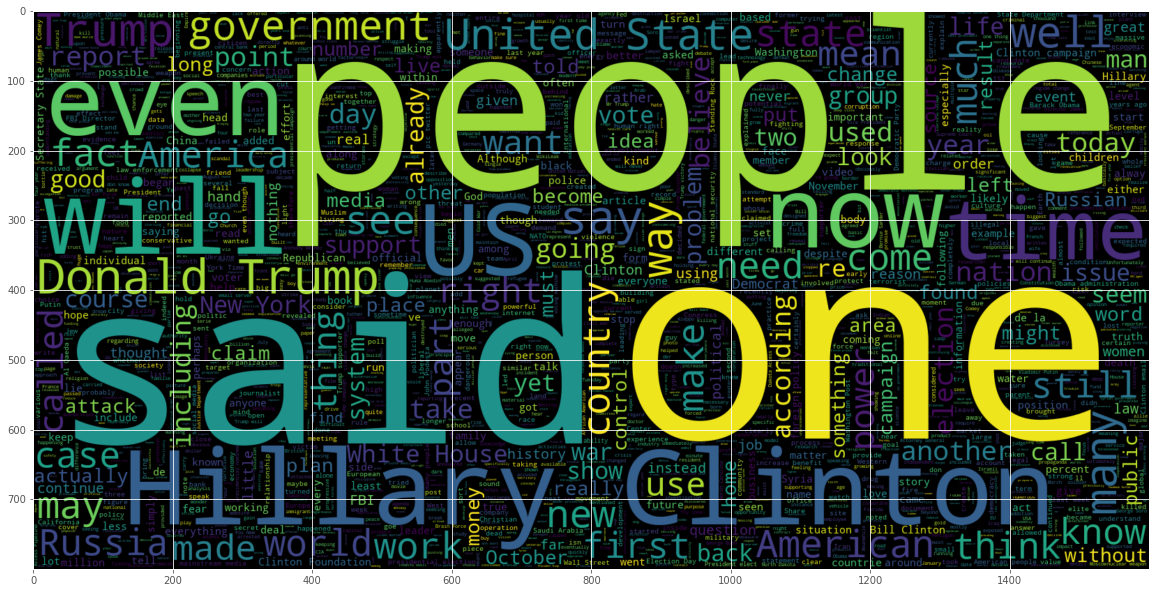

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_news[df_news.label == 1].text))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df_news["content"]], nbins = 100)
fig.show()

In [ ]:
len(y)

20759

In [ ]:
x_vect = [text.split() for text in x.tolist()]
DIM = 100
wv2_model = gensim.models.Word2Vec(sentences=x_vect, size=DIM, window=10, min_count=1)

In [ ]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_vect)
word_index = tokenizer.word_index
vocab_size=len(word_index) + 1
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(x_vect)
x = pad_sequences(sequences, maxlen=1000)

163626


In [ ]:
filename = "tokenizer"
pickle.dump(tokenizer, open(filename, 'wb'))

In [ ]:
# Import tensor representations for words
vocab = tokenizer.word_index
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))
  for word, i in vocab.items():
    try:
      weight_matrix[i] = model.wv[word]
    except KeyError:
      pass
  return weight_matrix


In [ ]:
embeddings_matrix = get_weight_matrix(wv2_model)

In [ ]:
embeddings_matrix.shape

(163626, 100)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)

In [ ]:
    
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=DIM, input_length=1000, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
y_train.dtype

dtype('O')

In [ ]:
len(y)

20759

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         16362600  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16,479,977
Trainable params: 117,377
Non-trainable params: 16,362,600
_________________________________________________________________


In [ ]:
x.dtype

dtype('int32')

In [ ]:
history = model.fit(x, y, epochs=7, validation_split=0.3)

Epoch 1/7
455/455 [==============================] - 433s 947ms/step - loss: 0.2915 - accuracy: 0.8792 - val_loss: 0.2092 - val_accuracy: 0.9167
Epoch 2/7
455/455 [==============================] - 428s 940ms/step - loss: 0.1812 - accuracy: 0.9290 - val_loss: 0.1441 - val_accuracy: 0.9425
Epoch 3/7
455/455 [==============================] - 428s 941ms/step - loss: 0.1152 - accuracy: 0.9587 - val_loss: 0.1156 - val_accuracy: 0.9571
Epoch 4/7
455/455 [==============================] - 428s 942ms/step - loss: 0.0824 - accuracy: 0.9700 - val_loss: 0.1068 - val_accuracy: 0.9599
Epoch 5/7
455/455 [==============================] - 425s 935ms/step - loss: 0.0597 - accuracy: 0.9790 - val_loss: 0.0968 - val_accuracy: 0.9648
Epoch 6/7
455/455 [==============================] - 431s 948ms/step - loss: 0.0494 - accuracy: 0.9828 - val_loss: 0.1134 - val_accuracy: 0.9624
Epoch 7/7
455/455 [==============================] - 429s 943ms/step - loss: 0.0382 - accuracy: 0.9866 - val_loss: 0.1204 - val_ac

In [ ]:
x = ["this is news"]
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=1000)
# (model.predict(x) >= 0.5).astype(int)[0][0]
model.predict(x)

array([[0.9925858]], dtype=float32)

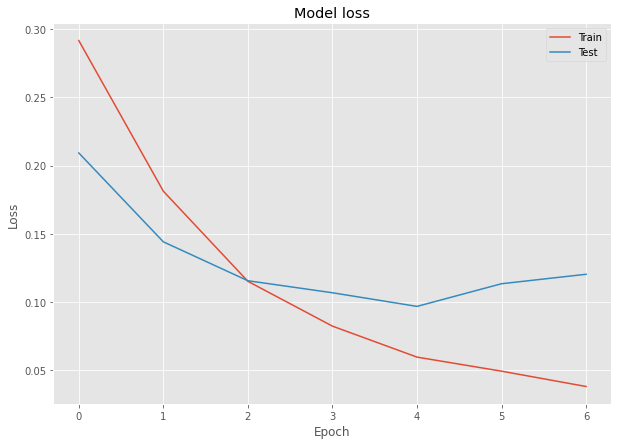

In [ ]:
# Visualize the results:
plt.figure(figsize=(10, 7))
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_true_rep=[df_true['text'][i].replace('WASHINGTON (Reuters) - ','').replace('LONDON (Reuters) - ','').replace('(Reuters) - ','') for i in range(len(df_true['text']))]
df_true['text']=df_true_rep

def predict_news(news):
    news = preprocessor(news)
    news = tokenizer.texts_to_sequences([news])
    news = pad_sequences(news, maxlen=1000)
    predict_news = (model.predict(news) >= 0.5).astype(int)[0][0]
    return predict_news

In [ ]:
fake_predictions = []
real_predictions = []
for i in df_true["text"]:
    if predict_news(i) == 0:
        real_predictions.append(i)
for i in df_fake["text"]:
    if predict_news(i) == 1:
        fake_predictions.append(i)

fake_prediction_accuracy = (len(fake_predictions) / len(df_fake)) * 100
real_prediction_accuracy = (len(real_predictions) / len(df_true)) * 100
model_prediction_accuracy = (fake_prediction_accuracy + real_prediction_accuracy) / 2
print("Fake prediction accuracy: ", fake_prediction_accuracy)
print("Real prediction accuracy: ", real_prediction_accuracy)
print("Model prediction accuracy: ", model_prediction_accuracy)


Fake prediction accuracy:  83.58672969635023
Real prediction accuracy:  84.18546014848019
Model prediction accuracy:  83.88609492241521


In [ ]:
true_positives = len(real_predictions)
true_negatives = len(fake_predictions)
false_positives = len(df_true) - true_positives
false_negatives = len(df_fake) - true_negatives

In [ ]:
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

In [ ]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.8418546014848018
Recall: 0.8238895997075489
F1 Score: 0.8327752245906561


In [ ]:
cf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])
cf_matrix

array([[19627,  3387],
       [ 3854, 18030]])

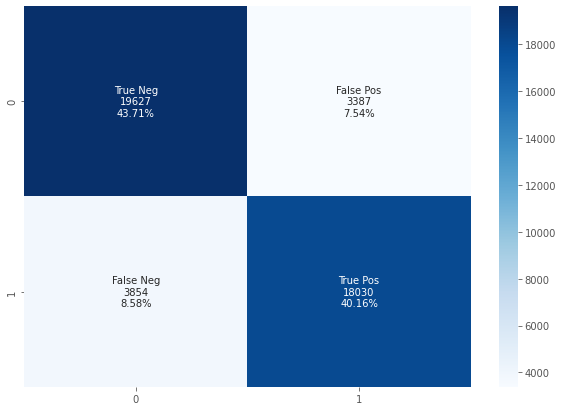

In [ ]:
plt.figure(figsize=(10, 7))
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [ ]:
true_negatives

19627

In [ ]:
saved_model_path = "/tmp/tf_save"
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model.save(saved_model_path, options=save_options)

INFO:tensorflow:Assets written to: /tmp/tf_save/assets


INFO:tensorflow:Assets written to: /tmp/tf_save/assets


In [ ]:
another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
  loaded = tf.keras.models.load_model(saved_model_path, options=load_options)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
import pickle

In [ ]:
filename = "fakeNewsdetector_final"
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://caa679bf-94f2-4ebe-b3d8-c92b19660d47/assets


INFO:tensorflow:Assets written to: ram://caa679bf-94f2-4ebe-b3d8-c92b19660d47/assets


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
z = ["this is news"]
z = tokenizer.texts_to_sequences(z)
z = pad_sequences(z, maxlen=1000)
(loaded.predict(z) >= 0.5).astype(int)[0][0]

1